# Part 1 - Data Exploration 


# Understanding the data and setting an objective



In [19]:
import pandas as pd       
import os 
import math 
import numpy as np
import matplotlib.pyplot as plt  
import IPython.display as ipd  # To play sound in the notebook
import librosa
import librosa.display
import os
os.chdir("../data/raw/speech-accent-archive")

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/speech-accent-archive'

In [20]:
!ls

reading-passage.txt  recordings  speakers_all.csv


------------------------------
After loading the libraries and setting our directory path, lets check out the meta datafile to see what we're dealing with 

In [21]:
#load the data 
df = pd.read_csv("speakers_all.csv", header=0)

# Check the data
print(df.shape, 'is the shape of the dataset') 
print('------------------------') 
print(df.head())

(2172, 12) is the shape of the dataset
------------------------
    age  age_onset              birthplace  filename native_language   sex  \
0  24.0       12.0         koussi, senegal   balanta         balanta  male   
1  18.0       10.0          buea, cameroon  cameroon        cameroon  male   
2  48.0        8.0  hong, adamawa, nigeria  fulfulde        fulfulde  male   
3  42.0       42.0   port-au-prince, haiti   haitian         haitian  male   
4  40.0       35.0   port-au-prince, haiti   haitian         haitian  male   

   speakerid   country  file_missing?  Unnamed: 9  Unnamed: 10 Unnamed: 11  
0        788   senegal           True         NaN          NaN         NaN  
1       1953  cameroon           True         NaN          NaN         NaN  
2       1037   nigeria           True         NaN          NaN         NaN  
3       1165     haiti           True         NaN          NaN         NaN  
4       1166     haiti           True         NaN          NaN         NaN  


------------------------------
I noticed some strange empty columns in the last 3 columns of the dataset. Lets clean it up and run some more stats and plots

In [22]:
df.drop(df.columns[9:12],axis = 1, inplace = True)
print(df.columns)
df.describe()

Index(['age', 'age_onset', 'birthplace', 'filename', 'native_language', 'sex',
       'speakerid', 'country', 'file_missing?'],
      dtype='object')


age    age_onset    speakerid
count  2172.000000  2172.000000  2172.000000
mean     33.117173     8.833333  1088.449355
std      14.453039     8.451127   628.420329
min       0.000000     0.000000     1.000000
25%      22.000000     0.000000   543.750000
50%      28.000000     8.000000  1088.500000
75%      41.000000    13.000000  1632.250000
max      97.000000    86.000000  2176.000000

------------------------------
Not sure what the differences are for age and age_onset but not important at this stage. Nothing really outstanding at the moment... lets soldier on

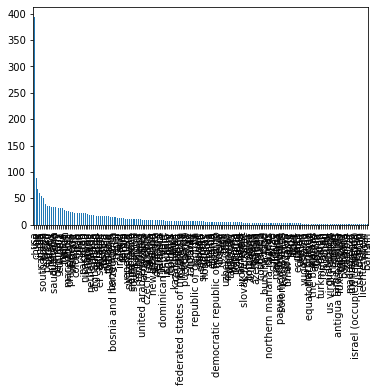

In [23]:
# Very rough plot
df['country'].value_counts().plot(kind='bar')

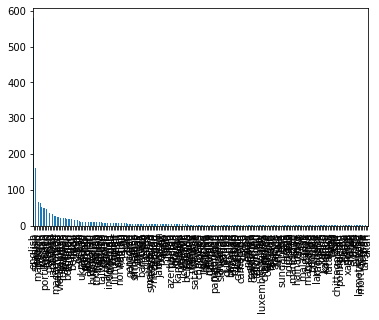

In [24]:
# Ok so that plot wasn't very good for that category. Lets try another category... 
df['native_language'].value_counts().plot(kind='bar')

In [25]:
# That's lots of categories too! Ok so maybe lets try a different way...
df.groupby("native_language")['age'].describe().sort_values(by=['count'],ascending=False)

count       mean        std   min    25%   50%   75%   max
native_language                                                            
english          579.0  34.482729  16.734510   6.0  21.00  29.0  44.0  90.0
spanish          162.0  34.129630  13.972528  17.0  23.00  30.0  45.0  80.0
arabic           102.0  30.950980  12.047248  18.0  21.25  28.0  38.0  70.0
mandarin          65.0  30.015385   8.193924  18.0  24.00  28.0  34.0  53.0
french            63.0  33.333333  16.246091  18.0  21.00  27.0  39.0  78.0
...                ...        ...        ...   ...    ...   ...   ...   ...
ife                1.0  30.000000        NaN  30.0  30.00  30.0  30.0  30.0
ilonggo            1.0  53.000000        NaN  53.0  53.00  53.0  53.0  53.0
irish              1.0  28.000000        NaN  28.0  28.00  28.0  28.0  28.0
jola               1.0  34.000000        NaN  34.0  34.00  34.0  34.0  34.0
zulu               1.0  24.000000        NaN  24.0  24.00  24.0  24.0  24.0

[214 rows x 8 columns]

------------------------------
Much better. No fancy visuals unfortunately but at least the insight comes through more in this format. The thing to note here is the lower number of Hindi speakers, which according to __[wikipedia](https://en.wikipedia.org/wiki/List_of_languages_by_number_of_native_speakers)__ is the 4th most spoken language, with alot of caveats of course. Eitherways, this tables looks like a pretty good representative sample in general to me. Lets look at country of origin again

In [26]:
# Check country of origin again...
df.groupby("country")['age'].describe().sort_values(by=['count'],ascending=False)

count       mean        std   min    25%   50%   75%   max
country                                                                      
usa                393.0  35.652672  18.044364   6.0  21.00  29.0  47.0  90.0
china               88.0  29.477273   9.654940  18.0  23.00  27.0  33.0  72.0
uk                  67.0  33.104478  14.900818  18.0  20.00  30.0  38.0  71.0
india               59.0  30.864407  11.501810  18.0  22.00  28.0  35.0  64.0
canada              54.0  31.629630  14.713998  18.0  21.25  26.5  37.5  78.0
...                  ...        ...        ...   ...    ...   ...   ...   ...
chad                 1.0  21.000000        NaN  21.0  21.00  21.0  21.0  21.0
burundi              1.0  36.000000        NaN  36.0  36.00  36.0  36.0  36.0
the bahamas          1.0  19.000000        NaN  19.0  19.00  19.0  19.0  19.0
malawi               1.0  42.000000        NaN  42.0  42.00  42.0  42.0  42.0
equatorial guinea    1.0  20.000000        NaN  20.0  20.00  20.0  20.0  20.0

[176 rows x 8 columns]

------------------------------
There's more native languages than there are countries which I suppose makes sense, although a hypothesis withstanding. A sankey type plot here would be interesting and very apprpriate to visualise this relationship, but lets park it for now as a seperate task. Right now, lets continue on with our main objective...

In [27]:
# Create DTM of counts 
df.groupby("sex")['age'].describe()

count       mean        std   min   25%   50%   75%   max
sex                                                               
famale     1.0  65.000000        NaN  65.0  65.0  65.0  65.0  65.0
female  1048.0  34.072519  15.337869   0.0  22.0  29.0  43.0  89.0
male    1123.0  32.197240  13.492936   0.0  22.0  28.0  39.0  97.0

In [28]:
# birthplace
df.groupby("birthplace")['age'].describe().sort_values(by=['count'],ascending=False)

count       mean        std   min   25%   50%  \
birthplace                                                                    
seoul, south korea             25.0  32.040000  12.300000  18.0  23.0  27.0   
skopje, macedonia              21.0  20.047619   1.160870  19.0  19.0  20.0   
hong kong, china               19.0  23.473684   4.753577  18.0  19.5  22.0   
addis ababa, ethiopia          16.0  28.875000   8.663140  20.0  22.5  27.5   
bogota, colombia               14.0  36.785714  20.881271  17.0  21.0  30.5   
...                             ...        ...        ...   ...   ...   ...   
jalandhar, india                1.0  42.000000        NaN  42.0  42.0  42.0   
jalisco, mexico                 1.0  45.000000        NaN  45.0  45.0  45.0   
jammu, kashmir, india           1.0  25.000000        NaN  25.0  25.0  25.0   
jamshedpur, jharkhand, india    1.0  29.000000        NaN  29.0  29.0  29.0   
lewisville, texas, usa          1.0  21.000000        NaN  21.0  21.0  21.0   

                                75%   max  
birthplace                                 
seoul, south korea            40.00  62.0  
skopje, macedonia             20.00  24.0  
hong kong, china              27.00  33.0  
addis ababa, ethiopia         31.00  52.0  
bogota, colombia              48.25  80.0  
...                             ...   ...  
jalandhar, india              42.00  42.0  
jalisco, mexico               45.00  45.0  
jammu, kashmir, india         25.00  25.0  
jamshedpur, jharkhand, india  29.00  29.0  
lewisville, texas, usa        21.00  21.0  

[1290 rows x 8 columns]

------------------------------
Birthplace is a very sparce datapoint with 1290 unique categories with very few observations in each one. Again could be interesting to see the patterns of Birthplace and Country relationship. Either a Network analysis or a Sankey plot may shed some light on whether all the Seoul birthplace observation equates to country. Ie. Could they be South Koreans living else where such as China or USA? 

Lets look at the file_missing column

In [29]:
# file_missing
df.groupby("file_missing?")['age'].describe().sort_values(by=['count'],ascending=False)

count       mean        std   min   25%   50%   75%   max
file_missing?                                                            
False          2140.0  33.080607  14.444245   0.0  22.0  28.0  41.0  97.0
True             32.0  35.562500  15.063173  18.0  24.0  35.0  42.0  73.0

------------------------------
2140 files with 32 missing. What does this actually mean? I read the overview page and there's no mention of this. So, lets go see it for ourselves... by counting the number of audio files we got

In [32]:
recordings_path = "/home/bithika/reSpeecher_voice_conversion/data/raw/speech-accent-archive/recordings/recordings"

In [33]:
# Count the total audio files given
print (len([name for name in os.listdir(recordings_path) if os.path.isfile(os.path.join(recordings_path, name))]))

2138


------------------------------
huh? 2138.... We have 2 missing audio files. Well, lets keep that in mind for now. We'll eventually find out which one's we're missing, and is really inconsequential either way given its just 2 files. Let continue on to the last column, the filename column

In [34]:
# filename column. This time we just print out the first 10 records. 
df.groupby("filename")['age'].describe().sort_values(by=['count'],ascending=False).head(10)

count       mean        std   min    25%   50%    75%   max
filename                                                               
haitian       6.0  36.333333  13.952300  18.0  25.75  41.0  42.75  54.0
swiss         5.0  30.200000   8.318654  21.0  24.00  30.0  34.00  42.0
nicaragua     4.0  37.000000  12.569805  20.0  32.75  39.0  43.25  50.0
jamaican      3.0  36.333333  28.307832  19.0  20.00  21.0  45.00  69.0
liberian      2.0  33.000000   7.071068  28.0  30.50  33.0  35.50  38.0
hawai'i       2.0  71.000000   2.828427  69.0  70.00  71.0  72.00  73.0
afrikaans1    1.0  27.000000        NaN  27.0  27.00  27.0  27.00  27.0
mandarin46    1.0  43.000000        NaN  43.0  43.00  43.0  43.00  43.0
mandarin42    1.0  47.000000        NaN  47.0  47.00  47.0  47.00  47.0
mandarin43    1.0  24.000000        NaN  24.0  24.00  24.0  24.00  24.0

------------------------------
Wait, there's some files that have the same filename. On closer inspection however, I suspect these filenames also have missing audio files. In which case it is ok. I have a suspicion that these dupe filenames also have missing audio files. So, lets have a look at doing a cross-tab of the 'filename' and 'file_missing?' column...

In [35]:
# Cross-tab. Again, just print the first 10 record 
df.groupby("filename")['file_missing?'].describe().sort_values(by=['count'],ascending=False).head(10)
# pd.crosstab(df['filename'],df['file_missing?']) as an alternative method 

count unique    top freq
filename                           
haitian        6      1   True    6
swiss          5      1   True    5
nicaragua      4      2   True    3
jamaican       3      1   True    3
liberian       2      1   True    2
hawai'i        2      1   True    2
afrikaans1     1      1  False    1
mandarin46     1      1  False    1
mandarin42     1      1  False    1
mandarin43     1      1  False    1

--------------------------------------
Ok so our suspicion is right, the filename with duplicate names have all missing audio files. Perfect! Everything checks out. We can go ahead a read in the audio files, and listen in to a few. We'll look at 'arikaans1' and 'mandarin46' since its on our periperal vision

In [42]:
# Play afrikaans1
fname1 = 'recordings/recordings/' + 'afrikaans1.mp3'
ipd.Audio(fname1)

In [43]:
fname1

'recordings/recordings/afrikaans1.mp3'

In [37]:
# Play mandarin46
fname2 = 'recordings/recordings/' + 'mandarin46.mp3'
ipd.Audio(fname2)

In [38]:
# lets have a listen to a male voice. 
print(df.groupby("filename")['sex'].describe().head(10))
fname3 = 'recordings/recordings/' + 'agni1.mp3'   
ipd.Audio(fname3)

           count unique     top freq
filename                            
afrikaans1     1      1  female    1
afrikaans2     1      1    male    1
afrikaans3     1      1    male    1
afrikaans4     1      1    male    1
afrikaans5     1      1    male    1
agni1          1      1    male    1
akan1          1      1    male    1
albanian1      1      1    male    1
albanian2      1      1    male    1
albanian3      1      1    male    1


------------------------------
Ok, so we've come to a point where we need to make a decision now. There's a few objectives worth pursuing on top of my head and they are: 
- building a gender predictor from voice
- building an accent predictor by Country from voice (or Birthplace)

All we could build all 2 applications above, starting from the easiest first being the gender predictor. The gender predictor will serve as our prototype and once we've built it, we'll expand to Country, and then maybe by Birthplace. I'm not even sure if Birthplace is viable objective but lets re-evaluate when we circle back to this. For now, **lets run with Gender first**. Also note that we don't have to limit ourselves with supervised modelling. There's many more we can do: 
- Audio fingerprinting 
- Emotion analysis (Text and Voice)
- Speed, inflection etc etc
- Others 

There's alot you can do with audio, but we'll look at these at a later stage. Meantime, the show must go on, and we will stick to our simple objective. Lets now run a few more examples of male and female audio files. This time, I want to hear the US Southern Accent. Cause I've always liked that accent and find it fascinating. =D

In [39]:
print(df[df['birthplace'].str.contains("kentucky",na=False)])
fname4 = 'recordings/recordings/' + 'english385.mp3'   
ipd.Audio(fname4)

      age  age_onset                   birthplace    filename native_language  \
420  31.0        0.0   brownsville, kentucky, usa  english150         english   
463  53.0        0.0    louisville, kentucky, usa   english19         english   
667  22.0        0.0  russellville, kentucky, usa  english373         english   
676  85.0        0.0   pike county, kentucky, usa  english381         english   
680  77.0        0.0       mcveigh, kentucky, usa  english385         english   
766  20.0        0.0       paducah, kentucky, usa  english462         english   

        sex  speakerid country  file_missing?  
420    male        527     usa          False  
463    male         76     usa          False  
667    male       1308     usa          False  
676    male       1324     usa          False  
680  female       1328     usa          False  
766    male       1564     usa          False  


In [40]:
fname5 = 'recordings/recordings/' + 'english462.mp3'   
ipd.Audio(fname5)

------------------------------
The male version which is filename 'english462' doesn't have a strong Southern accent. And there's some distrotion of the audio at the start. Could pose a problem for our accent predictor by Birthplace, but nothing to worry about for Gender. Looking at the previous tables and plots, seems like there's some potential age correlation here. So lets hear one final one! 

In [41]:
fname6 = 'recordings/recordings/' + 'english381.mp3'   # An older male 
ipd.Audio(fname6)

------------------------------
Ok so I'll end this kernel here now, and we'll go ahead with creating a gender predictor as our first mini-objective, with the ultimate objective being to create an accent predictor. The next logical step after this is to analyse the audio files itself and extract features from it, which we'll do in the Part 2 of this series, coming soon in the next 2 to 3 weeks hopefully!